<a href="https://colab.research.google.com/github/Orley74/ML_projects_python/blob/main/testy_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size

3670

In [ ]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes

5

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

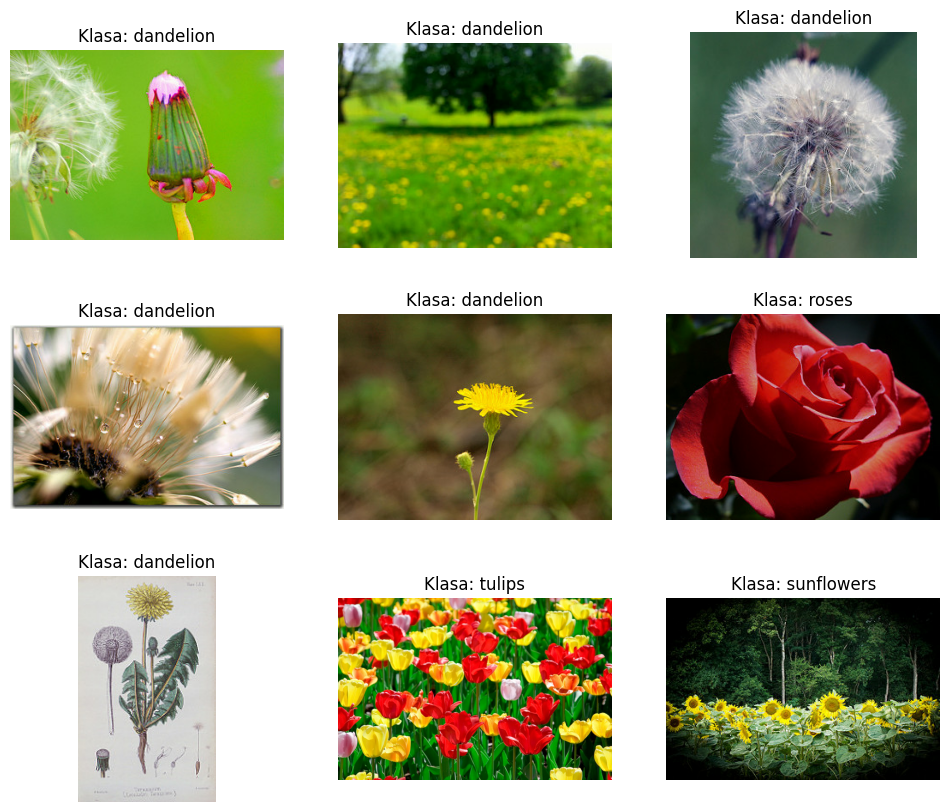

In [ ]:
# dodatkowy kod – wyświetla pierwszych 9 obrazów w zbiorze walidacyjnym
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Klasa: {class_names[label]}")
    plt.axis("off")

plt.show()

In [ ]:
tf.keras.backend.clear_session()  # dodatkowy kod – zeruje licznik nazw warstwy

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

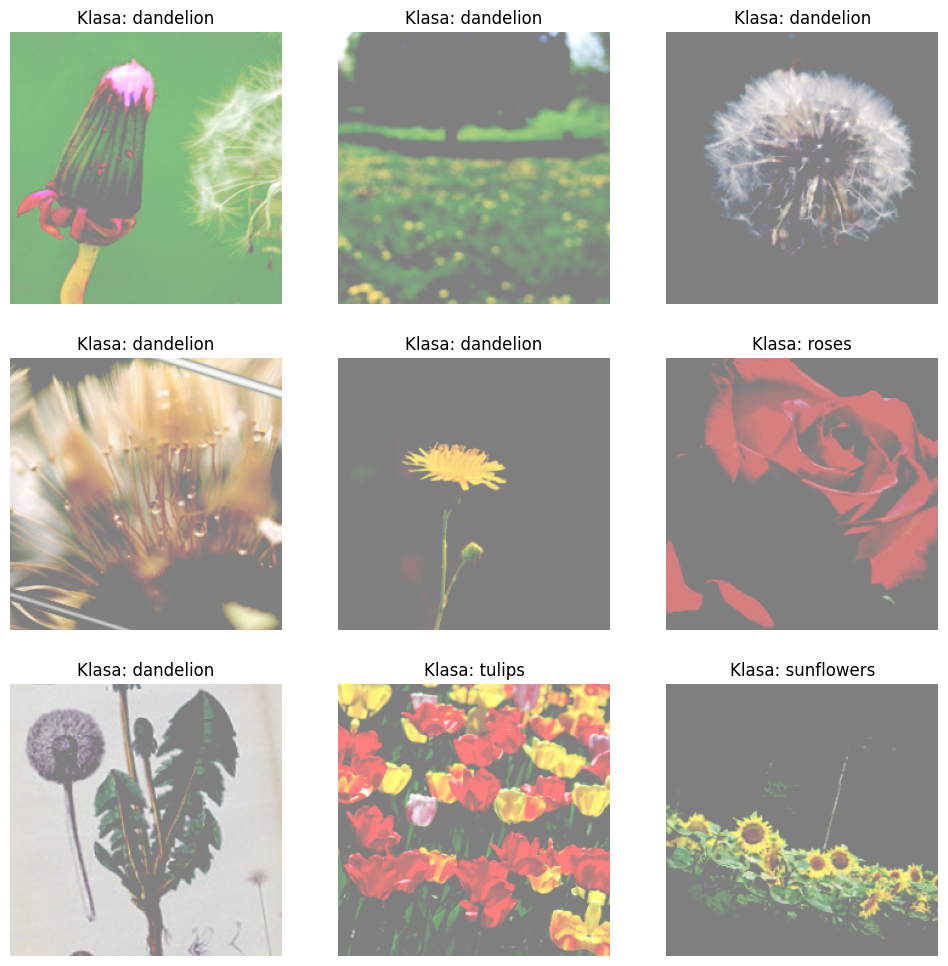

In [ ]:
# dodatkowy kod – ukazuje tych samych 9 obrazów po dogenerowaniu danych
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Klasa: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [ ]:
tf.random.set_seed(42)  # dodatkowy kod – gwarantuje odtwarzalność
base_model = tf.keras.applications.xception.Xception(weights="imagenet",

include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                    outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # zależy, co chcesz uzyskać
              optimizer=optimizer, metrics=["accuracy","accuracy"])

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# dodatkowy kod – dopasowuje model za pomocą losowych docelowych ramek ograniczających (w rzeczywistych
#              zastosowaniach musiałbyś stworzyć właściwe zmienne docelowe)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 313s 29s/step - dense_4_accuracy: 0.3995 - dense_4_loss: 1.3038 - dense_5_accuracy: 0.2026 - dense_5_loss: 0.2719 - loss: 1.0974
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 315s 28s/step - dense_4_accuracy: 0.8599 - dense_4_loss: 0.3649 - dense_5_accuracy: 0.2278 - dense_5_loss: 0.2094 - loss: 0.3338


In [ ]:
for i in fake_train_set.take(1):
  print(i)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[ 0.27328193,  0.2193253 , -0.3130626 ],
         [ 0.29433393,  0.24037743, -0.27383214],
         [ 0.29472804,  0.24313486, -0.17202383],
         ...,
         [-0.9687699 , -0.9687699 , -0.9687699 ],
         [-0.96258956, -0.96258956, -0.96258956],
         [-0.961257  , -0.961257  , -0.961257  ]],

        [[ 0.29566658,  0.257869  , -0.2568565 ],
         [ 0.27173352,  0.23419237, -0.26553267],
         [ 0.24757361,  0.2135576 , -0.20618713],
         ...,
         [-0.97099084, -0.97099084, -0.97099084],
         [-0.96862745, -0.96862745, -0.96862745],
         [-0.9699601 , -0.9699601 , -0.9699601 ]],

        [[ 0.30001986,  0.2733742 , -0.21643907],
         [ 0.24950981,  0.22428215, -0.25031906],
         [ 0.20623255,  0.18836892, -0.2271716 ],
         ...,
         [-0.9726421 , -0.9726421 , -0.9726421 ],
         [-0.9709909 , -0.9709909 , -0.9709909 ],
         [-0.9761404 , -0.9761404 , -0.97614